# Initial Sleep-EDF data exploration

This notebook explores the [Sleep-EDF Database Expanded](https://physionet.org/content/sleep-edfx/1.0.0/) from PhysioNet, which contains 197 whole-night polysomnographic sleep recordings. The dataset includes data from two studies:

1. **Sleep Cassette (SC)** - 153 recordings from 78 healthy subjects (aged 25-101) without sleep-related disorders
2. **Sleep Telemetry (ST)** - 44 recordings from subjects with mild difficulty falling asleep

Each recording contains physiological signals recorded during sleep, along with expert annotations of sleep stages.

## Data Structure

The dataset is organized in two main folders:

- **sleep-cassette/**: contains recordings from the Sleep Cassette study
- **sleep-telemetry/**: contains recordings from the Sleep Telemetry study

For each subject, there are two primary files:
- **[ID]-PSG.edf**: the polysomnography recording containing all physiological signals
- **[ID]-Hypnogram.edf**: the annotations of sleep stages by human experts

Additional metadata is available in:
- **SC-subjects.xls**: information about subjects in the Sleep Cassette study
- **ST-subjects.xls**: information about subjects in the Sleep Telemetry study

## Signal Dictionary

### PSG Files
Each PSG file contains multiple channels:

| Channel | Description | Sampling Rate |
|---------|-------------|---------------|
| EEG Fpz-Cz | Electroencephalogram (frontal-central) | 100 Hz |
| EEG Pz-Oz | Electroencephalogram (parietal-occipital) | 100 Hz |
| EOG horizontal | Electrooculogram (eye movements) | 100 Hz |
| EMG submental | Electromyogram (chin muscle activity) | 100 Hz |
| Event marker | Annotations of events | Variable |
| Body temperature | Temperature measurements (not in all recordings) | 1 Hz |
| Respiration | Respiratory signal (not in all recordings) | 1 Hz |

### Hypnogram Files
Sleep stages are coded according to the Rechtschaffen and Kales (R&K) manual:

| Code | Sleep Stage | Description |
|------|-------------|-------------|
| 0 | W | Wake |
| 1 | 1 | Non-REM stage 1 |
| 2 | 2 | Non-REM stage 2 |
| 3 | 3 | Non-REM stage 3 |
| 4 | 4 | Non-REM stage 4 |
| 5 | R | REM sleep |
| 6 | M | Movement time |
| 9 | ? | Unknown |

Sleep stages 3 & 4 are often combined in modern scoring as N3 (slow-wave sleep).

## Technical Information

- **File Format**: European Data Format (EDF)
- **Recording Duration**: typically ~20 hours, including pre-sleep and post-sleep periods
- **Annotation Intervals**: sleep stages are annotated in 30-second epochs
- **Main Paper**: [The Sleep-EDF Database Expanded](https://doi.org/10.1109/TBME.2018.2872652)

In this notebook, we'll use the MNE-Python library to load and analyze these EDF files.

## Basic dataset overview

We'll start exploring the data by examining the following:
- Number of subjects/recordings
- Recording metadata
- Recording durations
- Available channels/signals
- Sampling rates

### Number of recordings

In [1]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Set up plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set base path to data directory
base_dir = Path("../data/raw/sleep-edf")

# Define paths to each study
sc_dir = base_dir / "sleep-cassette"
st_dir = base_dir / "sleep-telemetry"

# Find all PSG and hypnogram files from both studies
sc_psg_files = list(sc_dir.glob("*-PSG.edf"))
sc_hypno_files = list(sc_dir.glob("*-Hypnogram.edf"))

st_psg_files = list(st_dir.glob("*-PSG.edf"))
st_hypno_files = list(st_dir.glob("*-Hypnogram.edf"))

# Combine all files but keep track of their origin
psg_files = sc_psg_files + st_psg_files
hypno_files = sc_hypno_files + st_hypno_files

# Create dictionaries to map files to their study
file_to_study = {}
for f in sc_psg_files + sc_hypno_files:
    file_to_study[f] = "Sleep Cassette"
for f in st_psg_files + st_hypno_files:
    file_to_study[f] = "Sleep Telemetry"

# Print summary statistics
print(f"Sleep Cassette study: {len(sc_psg_files)} PSG files, {len(sc_hypno_files)} hypnogram files")
print(f"Sleep Telemetry study: {len(st_psg_files)} PSG files, {len(st_hypno_files)} hypnogram files")
print(f"Total: {len(psg_files)} PSG files, {len(hypno_files)} hypnogram files")

# Count unique subjects by study
sc_subject_ids = set([f.name.split('-')[0] for f in sc_psg_files])
st_subject_ids = set([f.name.split('-')[0] for f in st_psg_files])

print(f"Number of unique subjects in Sleep Cassette: {len(sc_subject_ids)}")
print(f"Number of unique subjects in Sleep Telemetry: {len(st_subject_ids)}")
print(f"Total unique subjects: {len(sc_subject_ids) + len(st_subject_ids)}")

Sleep Cassette study: 153 PSG files, 153 hypnogram files
Sleep Telemetry study: 44 PSG files, 44 hypnogram files
Total: 197 PSG files, 197 hypnogram files
Number of unique subjects in Sleep Cassette: 153
Number of unique subjects in Sleep Telemetry: 44
Total unique subjects: 197


With the knowledge that we have the declared 197 files at our disposal, we can move on to extracting the meta-data of the EDF files, and converting said meta-data into a DataFrame for easier analysis. For this, we'll be using a sample of 20 files to avoid long processing times.

### Recording metadata

In [2]:
# Function to extract key metadata from EDF files
def extract_edf_info(file_path):
    """Extract basic metadata from an EDF file"""
    raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
    info = {
        'file_name': Path(file_path).name,
        'subject_id': Path(file_path).name.split('-')[0],
        'n_channels': len(raw.ch_names),
        'channel_names': raw.ch_names,
        'duration_seconds': raw.times[-1],
        'duration_hours': raw.times[-1] / 3600,
        'sampling_rate': raw.info['sfreq'],
        'start_time': raw.info['meas_date']
    }
    return info

# Analyse a subset of files to avoid long processing times
sample_size = min(20, len(psg_files))  # Limit to 20 files for a representative sample
psg_sample = psg_files[:sample_size]

# Extract metadata
recordings_info = []
for file_path in psg_sample:
    print(f"Processing {Path(file_path).name}...")
    try:
        info = extract_edf_info(file_path)
        recordings_info.append(info)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to DataFrame for easier analysis
recordings_df = pd.DataFrame(recordings_info)

Processing SC4001E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4002E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4011E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4012E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4

C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path,

Processing SC4022E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4031E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4032E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4041E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4

C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path,

Processing SC4051E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4052E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4061E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4062E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4

C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path,

Processing SC4072E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4081E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4082E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4091E0-PSG.edf...
Extracting EDF parameters from c:\Users\lucan\OneDrive\Programming\GitHub\medical-sensor-anomaly-detection\data\raw\sleep-edf\sleep-cassette\SC4

C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=False) # Only load header info into memory
C:\Users\lucan\AppData\Local\Temp\ipykernel_17420\3500687813.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path,

We can see several runtime warnings above.

First, we have a warning about **different filter settings**:
```
RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
```
This is fairly common in EEG/PSG data; different physiological signals require different filtering. The EDF file stores these filter settings, and these runtime warnings in specific are simply MNE's way of warning us it can only store one value in its internal representation.

More concerning is the **filter inconsistency**. For instance:
```
RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
```

> 🧠 **Highpass vs lowpass**
>
> This shouldn't be happening, as the highpass filter cutoff should be lower than the lowpass filter cutoff, rather than the other way around.

This suggests some channels have filter settings that don't really make sense (highpass > lowpass). This could indicate a number of things, primarily:
- Metadata errors in the original recordings
- Channel-specific settings that weren't sufficiently documented (e.g., different channels were recorded with different filter settings, which is to be expected)
- Conflicting filter settings in some channels (highpass > lowpass, which is problematic)

We'll move forward with this data as is, but will need to take this into account when we reach the data anomaly detection part of this project; we'll need to account for the different signal characteristics.

### Recording durations


Recording durations summary (hours):
count    20.000000
mean     23.055831
std       0.628706
min      21.416664
25%      22.766664
50%      23.283331
75%      23.437497
max      23.816664
Name: duration_hours, dtype: float64


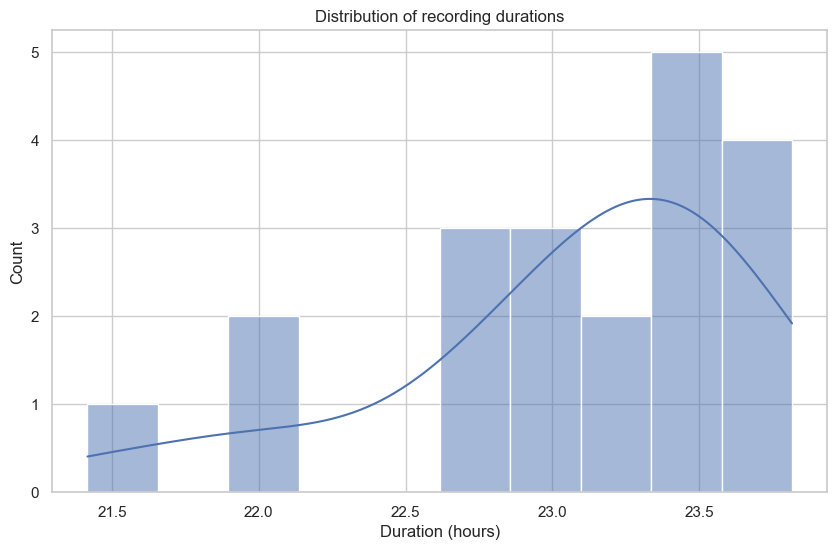

In [3]:
if len(recordings_df) > 0:
    # Summary statistics for recording durations
    print("\nRecording durations summary (hours):")
    duration_stats = recordings_df['duration_hours'].describe()
    print(duration_stats)
    
    # Plot histogram of recording durations
    plt.figure(figsize=(10, 6))
    sns.histplot(recordings_df['duration_hours'], kde=True, bins=10)
    plt.title('Distribution of recording durations')
    plt.xlabel('Duration (hours)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

We used a sample size of 20 to get a rough estimate of the recording durations across the 197 files (casette and telemetry). What we see is that:

- The recording durations vary roughly between 21 and 24 hours.
- The mean recording duration is ± 23.06 with a standard deviation of ± 0.63 (coefficient of deviation ≈ 0.03), further suggesting minimal spread of recording duration data.
- It looks like the majority of recording durations sits north of 22.5 hours.

Note that this data doesn't tell us if the recordings include the full sleep period, and it doesn't tell us why certain recordings were longer than others, either.

With this context available to us, we can examine available channels and sampling rates.

### Available channels and sampling rates


Channel availability:
channel_name
EEG Fpz-Cz        20
EEG Pz-Oz         20
EOG horizontal    20
Resp oro-nasal    20
EMG submental     20
Temp rectal       20
Event marker      20
Name: count, dtype: int64

Sampling rates (Hz):
sampling_rate
100.0    20
Name: count, dtype: int64


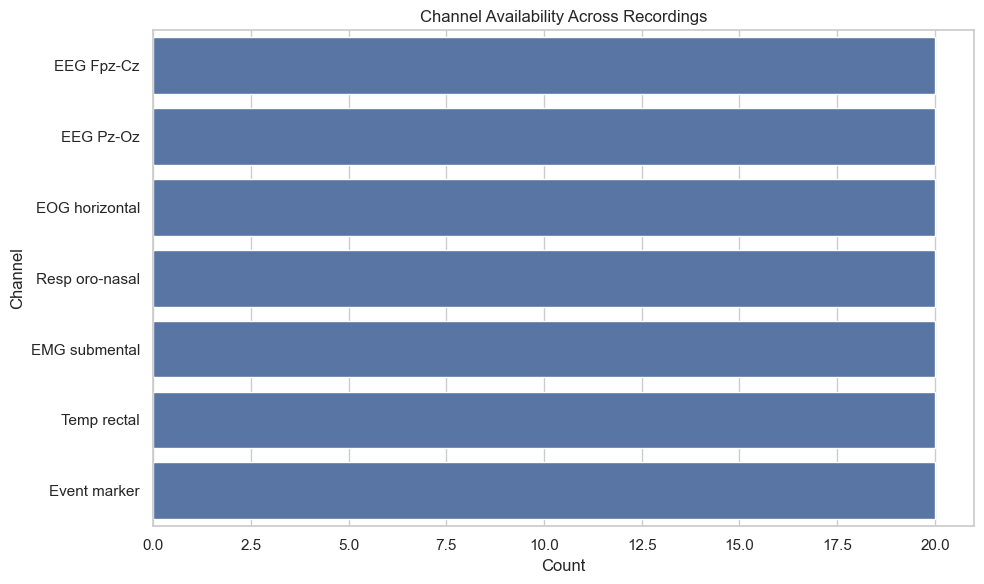

In [4]:
if len(recordings_df) > 0:
    # Explode the channel names for analysis
    channels_df = pd.DataFrame({
        'subject_id': np.repeat(recordings_df['subject_id'].values, 
                               [len(x) for x in recordings_df['channel_names']]),
        'channel_name': np.concatenate(recordings_df['channel_names'].values)
    })
    
    # Count occurrence of each channel
    channel_counts = channels_df['channel_name'].value_counts()
    print("\nChannel availability:")
    print(channel_counts)
    
    # Check consistency of sampling rates
    print("\nSampling rates (Hz):")
    print(recordings_df['sampling_rate'].value_counts())
    
    # Visualize channel availability
    plt.figure(figsize=(10, 6))
    sns.countplot(y='channel_name', data=channels_df)
    plt.title('Channel Availability Across Recordings')
    plt.xlabel('Count')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

This reveals that our sample of 20 contains 20 counts of the various channels as described on Physionet (see graph above). However, it should be noted that Kemp (the author) expressed that the files _"often"_ contain rectal body temperature measurements, meaning that we can expect some missing data once we start cleaning up the dataset, or perhaps placeholder/null values. Conversely, we might be dealing with sample bias, or the data was standardised even after its documentation was last updated.

It also shows us that all recordings have the same sampling rate of 100 Hz. However, on Physionet, it is stated that oro-nasal airflow, rectal body temperature and event markers (as well as the submental EMG expressed in root-mean-square (RMS)) are in fact sampled at 1 Hz. Most likely this means this data is stored at 100 Hz (repeated values), while in fact containing 1-Hz information. Alternatively, MNE may simply be reporting technical sampling rate rather than physiologically meaningful data.

On Physionet, it is stated that these three channels (as well as the submental EMG expressed in root-mean-square (RMS)) are in fact sampled at 1 Hz, in any event.

The discrepancy has some implications:

1. **Signal-specific processing:** we'll need different approaches for:
    - Fast-changing signals (EEG at 100 Hz captures brain oscillations up to ~50 Hz)
    - Slow-changing signals (body temperature changes happen over minutes, not milliseconds)
2. **Feature engineering:** When extracting features, we should:
    - Consider downsampling the 1 Hz channels to their effective rate before analysis
    - Avoid extracting high-frequency features from signals that are effectively 1 Hz
3. **Anomaly detection sensitivity:** our models will need different sensitivity thresholds:
    - EEG anomalies might occur in milliseconds
    - Temperature anomalies are likely only be meaningful over minutes or hours, because human body temperature doesn't meaningfully vary between seconds
4. **Storage efficiency** — processing 100 Hz data for channels that effectively contain 1 Hz information wastes computational resources